# Baseline Model - Deep Learning

After investigatng NASA data, let's develop an simple baseline model. 

For simplicity, we will divide features into two categories: 

1. Charge Feature Sets
2. Discharge Feature Sets

Aim: Predict Capacity in Discharge Feature Set

## 1. Feature Set - Discharge

### 0. Preprocessing

In [4]:
import scipy.io
import pandas as pd
root = '/home/di0002ya/ESS/data/NASA/'

In [5]:
def save2df(root,name):
    temp= pd.read_csv(root+ name)
    return temp

In [109]:
B5Charge = save2df(root,'B0005_Charge.csv')
B5Discharge = save2df(root,'B0005_Discharge.csv')
B6Charge = save2df(root,'B0006_Charge.csv')
B6Discharge = save2df(root,'B0006_Discharge.csv')
B7Charge = save2df(root,'B0007_Charge.csv')
B7Discharge = save2df(root,'B0007_Discharge.csv')
B18Charge = save2df(root,'B0018_Charge.csv')
B18Discharge = save2df(root,'B0018_Discharge.csv')

In [110]:
import numpy as np
def data_pre(df):
    x1 = np.arange(df.shape[0])
    # Convert Time_root to cycle 
    unique_ar = np.unique(df[['Time_root']])
    cycle_index = np.arange(unique_ar.shape[0])
    zipbObj = zip(unique_ar, cycle_index)
    dictOfWords = dict(zipbObj)
    df['Cycle'] = df['Time_root'].map(dictOfWords)
    return df 

In [111]:
B5Charge = data_pre(B5Charge)
B5Discharge = data_pre(B5Discharge)
B6Charge = data_pre(B6Charge)
B6Discharge = data_pre(B6Discharge)
B7Charge = data_pre(B7Charge)
B7Discharge = data_pre(B7Discharge)
B18Charge = data_pre(B18Charge)
B18Discharge = data_pre(B18Discharge)

### 1. Discharge Voltage Measured

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [10]:
cycle = np.arange(0,160,1).tolist()
df = B5Discharge
df.head(2)

,Temperature_root,Time_root,Time,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Capacity,Cycle
0,24,733500.642843,0.000,4.191492,-0.004902,24.330034,-0.0006,0.000,1.856487,0
1,24,733500.642843,16.781,4.190749,-0.001478,24.325993,-0.0006,4.206,1.856487,0


In [11]:
def dis_vm_feat(df,cycle,offset):
    temp_ls = []
    for i in range(len(cycle)):
        filter_rows = df.loc[df['Cycle'] == cycle[i]]
        filter_col = filter_rows['Voltage_measured']
        filter_col = filter_col.reset_index(drop=True)
        # 1. End Index & Offset 
        end_index = filter_col.index[-1]
        end_index_ls = np.arange(end_index-offset,end_index+1)
        end_value_ls = filter_col[end_index_ls]
        # 2. 2nd order differential top N max
        dx = np.gradient(np.array(filter_col))
        ddx = np.gradient(dx)
        max2_index_ls = np.argsort(ddx)[-offset:][::-1]
        max2_value_ls = filter_col[np.array(max2_index_ls)]
        # 3. Consists 2 Dimensional Feature Datasets (x1(index) vs x2(value))
        X1 = np.hstack((max2_index_ls,end_index_ls))
        X2 = np.hstack((max2_value_ls,end_value_ls))
        temp = np.vstack((X1,X2))
        temp_ls.append(temp)
    feat = np.stack(temp_ls)
    return feat

In [12]:
dis_vm = dis_vm_feat(df,cycle,offset=4)

In [15]:
# Draw Select Features 
def plot_select(df,feat,cycle,i,select):
    filter_rows = df.loc[df['Cycle'] == cycle[i]]
    filter_col = filter_rows[select]
    drawing_pt = feat[i][0]
    t = np.arange(filter_col.shape[0])

    xs = feat[i][0]
    ys = feat[i][1]
    xs = xs.astype(int)
    plt.scatter(xs, ys, marker='o',color='r')
    plt.plot(t,filter_col)
    plt.xlabel('Pts per cycle')
    plt.ylabel('Value')
    plt.show()

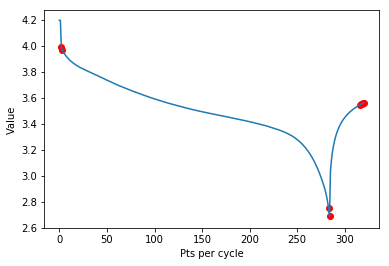

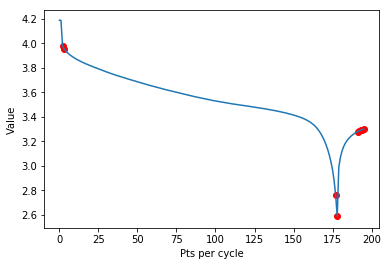

In [16]:
i = 100
plot_select(df=df,feat=dis_vm, cycle =cycle,i = i,select='Voltage_measured')
i = 1
plot_select(df=df,feat=dis_vm, cycle =cycle,i = i,select='Voltage_measured')

### 2. Discharge Current Measured

In [53]:
def dis_cm_feat(df,cycle,offset):
    temp_ls = []
    for i in range(len(cycle)):
        filter_rows = df.loc[df['Cycle'] == cycle[i]]
        filter_col = filter_rows['Current_measured']
        filter_col = filter_col.reset_index(drop=True)
        # 2. 1st order differential top N max
        dx = np.gradient(np.array(filter_col))
#         max_index1 = np.unravel_index(np.argmin(dx, axis=None), dx.shape)[0]
        end_index = filter_col.index[-1]
        max_index2 = np.unravel_index(np.argmax(dx, axis=None), dx.shape)[0]
        index_ls = np.arange(0,offset)
        index_ls2 = np.arange(end_index-offset, end_index+1)
        index_ls3 = np.arange(max_index2-offset,max_index2+1)
        value_ls = filter_col[np.array(index_ls)]
        value_ls2 = filter_col[np.array(index_ls2)]        
        value_ls3 = filter_col[np.array(index_ls3)]  
        # 3. Consists 2 Dimensional Feature Datasets (x1(index) vs x2(value))
        X1 = np.hstack((index_ls,index_ls2,index_ls3))
        X2 = np.hstack((value_ls,value_ls2,value_ls3))
        temp = np.vstack((X1,X2))
        temp_ls.append(temp)
    feat = np.stack(temp_ls)
    return feat

In [54]:
dis_cm = dis_cm_feat(df,cycle,offset=10)

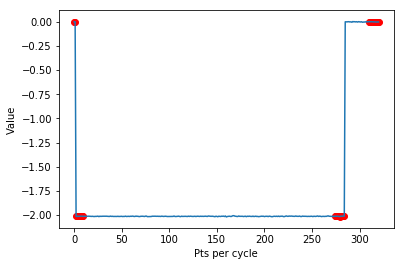

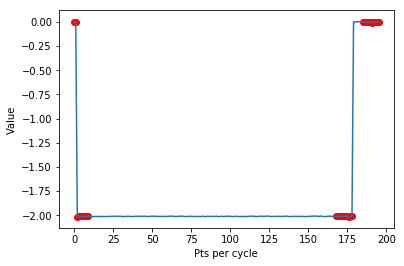

In [55]:
i = 100
plot_select(df=df,feat=dis_cm, cycle =cycle,i = i,select='Current_measured')
i = 1
plot_select(df=df,feat=dis_cm, cycle =cycle,i = i,select='Current_measured')

### 3. Discharge Current Load

In [56]:
def dis_cl_feat(df,cycle,offset):
    temp_ls = []
    for i in range(len(cycle)):
        filter_rows = df.loc[df['Cycle'] == cycle[i]]
        filter_col = filter_rows['Current_load']
        filter_col = filter_col.reset_index(drop=True)
        # 2. 1st order differential top N max
        dx = np.gradient(np.array(filter_col))
#         max_index1 = np.unravel_index(np.argmin(dx, axis=None), dx.shape)[0]
        end_index = filter_col.index[-1]
        max_index2 = np.unravel_index(np.argmax(dx, axis=None), dx.shape)[0]
        index_ls = np.arange(0,offset)
        index_ls2 = np.arange(end_index-offset, end_index+1)
        index_ls3 = np.arange(max_index2-offset,max_index2+1)
        value_ls = filter_col[np.array(index_ls)]
        value_ls2 = filter_col[np.array(index_ls2)]        
        value_ls3 = filter_col[np.array(index_ls3)]  
        # 3. Consists 2 Dimensional Feature Datasets (x1(index) vs x2(value))
        X1 = np.hstack((index_ls,index_ls2,index_ls3))
        X2 = np.hstack((value_ls,value_ls2,value_ls3))
        temp = np.vstack((X1,X2))
        temp_ls.append(temp)
    feat = np.stack(temp_ls)
    return feat

In [63]:
dis_cl = dis_cl_feat(df,cycle,offset=20)

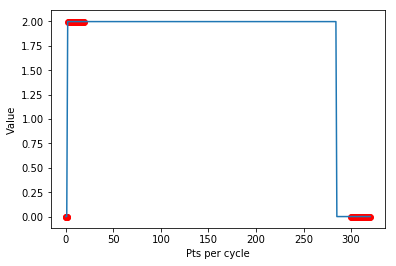

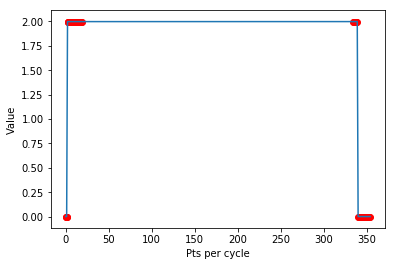

In [68]:
i = 100
plot_select(df=df,feat=dis_cl, cycle =cycle,i = i,select='Current_load')
i = 40
plot_select(df=df,feat=dis_cl, cycle =cycle,i = i,select='Current_load')

### 4. Discharge Voltage Load

In [73]:
def dis_vl_feat(df,cycle,offset):
    temp_ls = []
    for i in range(len(cycle)):
        filter_rows = df.loc[df['Cycle'] == cycle[i]]
        filter_col = filter_rows['Voltage_load']
        filter_col = filter_col.reset_index(drop=True)
        # 2. 1st order differential top N max
        dx = np.gradient(np.array(filter_col))
#         max_index1 = np.unravel_index(np.argmin(dx, axis=None), dx.shape)[0]
        end_index = filter_col.index[-1]
        index_ls = np.arange(end_index-offset, end_index+1)
        value_ls = filter_col[np.array(index_ls)] 
        # 3. Consists 2 Dimensional Feature Datasets (x1(index) vs x2(value))
        temp = np.vstack((index_ls,value_ls))
        temp_ls.append(temp)
    feat = np.stack(temp_ls)
    return feat

In [74]:
dis_vl = dis_vl_feat(df,cycle,offset=20)

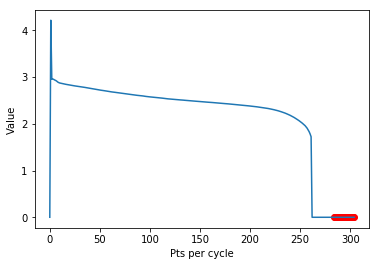

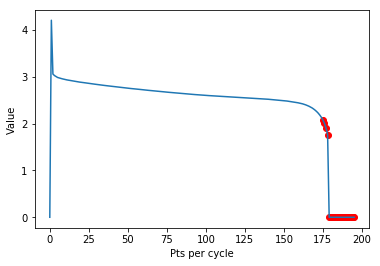

In [77]:
i = 150
plot_select(df=df,feat=dis_vl, cycle =cycle,i = i,select='Voltage_load')
i = 1
plot_select(df=df,feat=dis_vl, cycle =cycle,i = i,select='Voltage_load')

### 5. Target: Capacity

In [82]:
def capacity(df,cycle):
    temp_ls = []
    for i in range(len(cycle)):
        filter_rows = df.loc[df['Cycle'] == cycle[i]]
        filter_col = filter_rows['Capacity']
        filter_col = filter_col.reset_index(drop=True)
        # 2. 1st order differential top N max
        temp_ls.append(filter_col[0])
    return temp_ls

In [83]:
capacity_ar = np.array(capacity(df,cycle))

### 6. X: Final Features

In [86]:
print(dis_vl.shape)
print(dis_cl.shape)
print(dis_vm.shape)
print(dis_cm.shape)

(160, 2, 21)
(160, 2, 62)
(160, 2, 9)
(160, 2, 32)


## 2. Training Model - Discharge Feature Dataset

### 0. Get All Data

In [235]:
# Training Data 
df_ls = [B5Discharge,B6Discharge,B7Discharge]
X_ls = []
Y_ls = []
for i in range(len(df_ls)):
    df = df_ls[i]
    dis_vm = dis_vm_feat(df,cycle,offset=14)
    dis_cm = dis_cm_feat(df,cycle,offset=10)
    dis_cl = dis_cl_feat(df,cycle,offset=20)
    dis_vl = dis_vl_feat(df,cycle,offset=20)
    capacity_ar = np.array(capacity(df,cycle))
    X_ls.append(np.concatenate((dis_vm,dis_cm,dis_cl,dis_vl),axis=2))
    Y_ls.append(capacity_ar)
X_ar = np.concatenate(X_ls)
Y_ar = np.concatenate(Y_ls)

/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [236]:
X_ar.shape

(480, 2, 144)

In [237]:
Y_ar.shape

(480,)

Data is really insuffient. But let's try first.

### 1. Data Normalization

In [238]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_ar.reshape(X_ar.shape[0],-1))

In [239]:
X_train_minmax.shape

(480, 288)

In [240]:
X_norm = X_train_minmax.reshape(X_ar.shape[0],X_ar.shape[1],X_ar.shape[2])

In [241]:
X_norm.shape

(480, 2, 144)

In [242]:
Y_train_minmax = min_max_scaler.fit_transform(Y_ar.reshape(X_ar.shape[0],-1))

In [243]:
Y_norm = Y_train_minmax.reshape(Y_ar.shape)

In [244]:
# Shuffle Data 
s = np.arange(X_norm.shape[0])
np.random.shuffle(s)

In [245]:
X_norm_sf = X_norm[s]

In [246]:
Y_norm_sf = Y_norm[s]

In [247]:
X_norm_sf.shape

(480, 2, 144)

### 2. Build Model (Keras)

In [248]:
from keras.layers import LSTM, Dense, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential 

In [249]:
X = X_norm.reshape(X_norm.shape[0],-1)

In [250]:
X.shape

(480, 288)

In [261]:
model = Sequential()
model.add(Dense(128, input_shape=(288,),activation='relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'tanh'))
model.compile(loss='mae', optimizer='sgd')

In [262]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               36992     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 45,313
Trainable params: 45,313
Non-trainable params: 0
_________________________________________________________________


In [263]:
args = {}
args['batch'] = 4
args['epochs'] = 20

In [264]:
model.fit(X, Y_norm,
          batch_size = args['batch'], nb_epoch= args['epochs'], 
          verbose=2,validation_split=0.1)

/home/di0002ya/miniconda3/envs/quickdraw/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 432 samples, validate on 48 samples
Epoch 1/20
 - 1s - loss: 0.2577 - val_loss: 0.1355
Epoch 2/20
 - 0s - loss: 0.2145 - val_loss: 0.1677
Epoch 3/20
 - 0s - loss: 0.2140 - val_loss: 0.1688
Epoch 4/20
 - 0s - loss: 0.2148 - val_loss: 0.1708
Epoch 5/20
 - 0s - loss: 0.2142 - val_loss: 0.1674
Epoch 6/20
 - 0s - loss: 0.2141 - val_loss: 0.1688
Epoch 7/20
 - 0s - loss: 0.2146 - val_loss: 0.1656
Epoch 8/20
 - 0s - loss: 0.2139 - val_loss: 0.1619
Epoch 9/20
 - 0s - loss: 0.2145 - val_loss: 0.1684
Epoch 10/20
 - 0s - loss: 0.2141 - val_loss: 0.1549
Epoch 11/20
 - 0s - loss: 0.2142 - val_loss: 0.1713
Epoch 12/20
 - 0s - loss: 0.2134 - val_loss: 0.1963
Epoch 13/20
 - 0s - loss: 0.2138 - val_loss: 0.1882
Epoch 14/20
 - 0s - loss: 0.2143 - val_loss: 0.1799
Epoch 15/20
 - 0s - loss: 0.2143 - val_loss: 0.1861
Epoch 16/20
 - 0s - loss: 0.2147 - val_loss: 0.1689
Epoch 17/20
 - 0s - loss: 0.2139 - val_loss: 0.1896
Epoch 18/20
 - 0s - loss: 0.2146 - val_loss: 0.1769
Epoch 19/20
 - 0s - loss: 0.

In [265]:
Y_predict = model.predict(X)

In [266]:
Y_predict

array([[0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.49145788],
       [0.491